In [286]:
%matplotlib notebook  
import matplotlib.pyplot as plt   
import numpy as np

In [287]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt # for plotting          
import numpy as np

class Particle (object):

    """Class that describes particle"""
    m = 1.0

    def __init__(self, x0=1.0, v0=0.0,  tf = 10.0, dt = 0.001):
        self.x = x0
        self.v = v0
        self.t = 0.0
        self.tf = tf
        self.dt = dt

        self.tlabel = 'time (s)'
        self.xlabel = 'x (m)'
        self.vlabel = 'v (m/s)'

        npoints = int(tf/dt) # always starting at t = 0.0
        self.npoints = npoints
        self.tarray = np.linspace(0.0, tf,npoints, endpoint = True) # include final timepoint
        self.xv0 = np.array([self.x, self.v]) # NumPy array with initial position and velocity

    def F(self, x, v, t):
        # The force on a free particle is 0
        return array([0.0])

    def Euler_step(self): 
        """
        Take a single time step using Euler method
        """
        
        a = self.F(self.x, self.v, self.t) / self.m
        self.x += self.v * self.dt
        self.v += a * self.dt
        self.t += self.dt

    def RK4_step(self):
        """
        Take a single time step using RK4 midpoint method
        """

        a1 = self.F(self.x, self.v, self.t) / self.m
        k1 = np.array([self.v, a1])*self.dt

        a2 = self.F(self.x+k1[0]/2, self.v+k1[1]/2, self.t+self.dt/2) / self.m
        k2 = np.array([self.v+k1[1]/2 ,a2])*self.dt
        
        a3 = self.F(self.x+k2[0]/2, self.v+k2[1]/2, self.t+self.dt/2) / self.m
        k3 = np.array([self.v+k2[1]/2, a3])*self.dt
        
        a4 = self.F(self.x+k3[0], self.v+k3[1], self.t+self.dt) / self.m
        k4 = np.array([self.v+k3[1], a4])*self.dt

        self.x += (k1[0]+ k4[0])/6 + (k2[0] + k3[0])/3
        self.v += (k1[1]+ k4[1])/6 + (k2[1] + k3[1])/3
        
        self.t += self.dt

    def Euler_trajectory(self):
        """
        Loop over all time steps to construct a trajectory with Euler method
        Will reinitialize euler trajectory everytime this method is called
        """
        
        x_euler = []
        v_euler = []
        
        while(self.t < self.tf-self.dt/2):
            v_euler.append(self.v)
            x_euler.append(self.x)
            self.Euler_step()
        
        self.x_euler = np.array(x_euler)
        self.v_euler = np.array(v_euler)


    def RK4_trajectory(self):  # calculate trajectory as before
        # need to reinitialize if you want to call this method and others
        x_RK4 = []
        v_RK4 = []
        for ii in range(self.npoints):
            x_RK4.append(self.x)
            v_RK4.append(self.v)
            self.RK4_step()

        self.x_RK4 = np.array(x_RK4)
        self.v_RK4 = np.array(v_RK4)

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.xv = odeint(self.derivative, self.xv0, self.tarray)

    def derivative(self, xv, t):
        """right hand side of the differential equation"""
        x =xv[0]
        v =xv[1]
        a = self.F(x, v, t) / self.m
        return np.ravel(np.array([v, a]))

    def results(self):
        """
        Print out results in a nice format
        """

        
        print('\n\t Position and Velocity at Final Time:')
        print('Euler:')
        print('t = {} x = {} v = {}'.format(self.t, self.x , self.v))
        
        if hasattr(self, 'xv'):
            print('SciPy ODE Integrator:')
            print('t = {} x = {} v = {}'.format(self.tarray[-1], self.xv[-1, 0], self.xv[-1,1]))

    def plot(self, pt = 'trajectory'):
        """
        Make nice plots of our results
        """

        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        
        
        if hasattr(self,'xv'):

            if pt == 'trajectory':
                ax1.plot(self.tarray, self.xv[:, 0], "k", label = 'odeint')
            if pt == 'phase':
                ax1.plot(self.xv[:, 0], self.xv[:, 1], "k",'.', label = 'odeint')
        
        if hasattr(self,'x_euler'):

            if pt == 'trajectory':
                ax1.plot(self.tarray, self.x_euler, "b", label = 'euler')
            if pt == 'phase':
                ax1.plot(self.x_euler, self.v_euler, "b",'.', label = 'euler')
        
        if hasattr(self,'x_RK4'):

            if pt == 'trajectory':
                ax1.plot(self.tarray, self.x_RK4, "r", label = 'RK4')
            if pt == 'phase':
                ax1.plot(self.x_RK4, self.v_RK4, "b",'.', label = 'euler')
       
        if pt == 'trajectory':
            ax1.set_xlabel(self.tlabel)
            ax1.set_ylabel(self.xlabel)
        
        if pt == 'phase':
            ax1.set_xlabel(self.xlabel)
            ax1.set_ylabel(self.vlabel)


class Pendulum(Particle):

    """Subclass of Particle Class that describes a pendulum in a harmonic potential"""
    def __init__(self, l = 9.8, nu = 0, Fd  = 0.0, omega_d = 0.0, m = 1.0, x0 = 0.0 ,v0 = 0.0, tf = 50.0, dt = 0.001):
       
        super().__init__(x0,v0,tf,dt) 
        # for pendulum x = theta [-pi, pi]
        g = 9.8
        omega0 = np.sqrt(g/l)
        
        self.l = l # length
        self.m = m # mass
        self.Fd = Fd # driving force, in units of mg
        self.omega_d = omega_d #driving frequency, in units of omega0
        self.nu = nu # viscous damping 
        self.omega0 = omega0 # natural frequency

        self.tlabel = 'time ($1/\omega_0$)'
        self.xlabel = '$\\theta$ (radians)'
        self.vlabel = '$\omega$ (radians/s)'

    # overload method to wrap x between [-pi,pi]
    def RK4_step(self):  
        Particle.RK4_step(self)
        if self.x > np.pi:
            self.x -= 2*np.pi
        elif self.x < -np.pi:
            self.x += 2*np.pi

    # overload method to wrap x between [-pi,pi]
    def scipy_trajectory(self):
        Particle.scipy_trajectory(self)
        
        x = self.xv[:,0]
        x_new = np.zeros(np.shape(x))
        x_new[0] = x[0]
        x_usu = np.zeros(np.shape(x))
        x_usu[0] = x[0]

        # find change in x between each point
        dx = np.diff(x)
        nx = np.shape(x)[0]
        
        for ii in range(1,nx):
            # reconstruct x array, checking for out of range values
            x_new[ii] = x_new[ii-1]+dx[ii-1]
            x_usu[ii] = x_usu[ii-1]+dx[ii-1]
            if x_new[ii] > np.pi:
                x_new[ii] -= 2*np.pi
            
            elif x_new[ii] < -np.pi:
                x_new[ii] += 2*np.pi
        self.x_usu=np.transpose(np.array(x_usu))
        self.xv_unwrap = 1.0*self.xv
        self.xv[:,0] = x_new
    
    def F(self, x, v, t):
        g = 9.8 

        F = self.Fd*np.cos(self.omega_d*t) - self.nu*v - g/self.l*np.sin(x)
        
        return F

            


**Problem 1**

<IPython.core.display.Javascript object>


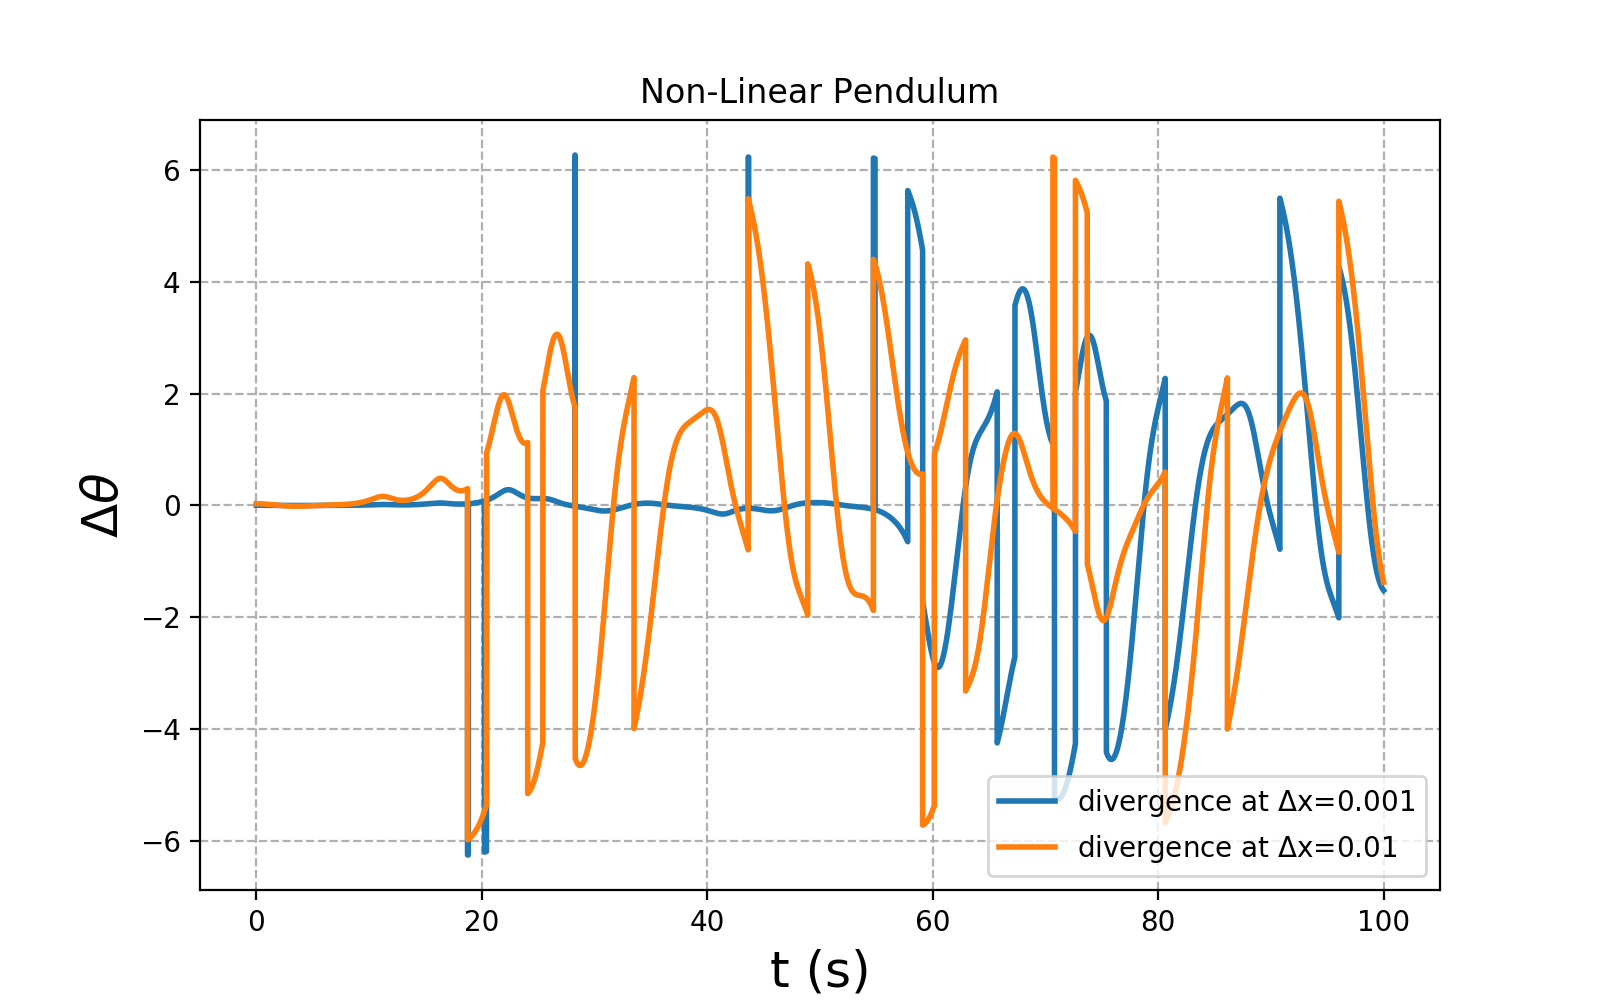

In [289]:
fig = plt.figure(figsize = [8,5])
ax = fig.add_subplot(111)
x0s= [0, 0.001,0.01] 
p1= Pendulum(nu = 0.5, Fd=1.1, x0 = np.pi*x0s[0], omega_d = 0.6, tf= 100, dt = 1e-3)
p2= Pendulum(nu = 0.5, Fd=1.1, x0 = np.pi*x0s[1], omega_d = 0.6, tf= 100, dt = 1e-3)
p3= Pendulum(nu = 0.5, Fd=1.1, x0 = np.pi*x0s[2], omega_d = 0.6, tf= 100, dt = 1e-3)
p1.scipy_trajectory() 
p2.scipy_trajectory() 
p3.scipy_trajectory() 
ax.plot(p1.tarray, p2.xv[:,0]-p1.xv[:,0], lw = 2, label = "divergence at $\\Delta$x={}".format(x0s[1]-x0s[0]))
ax.plot(p1.tarray, p3.xv[:,0]-p1.xv[:,0], lw = 2, label = "divergence at $\\Delta$x={}".format(x0s[2]-x0s[0]))

ax.grid(ls='--')
ax.set_xlabel('t (s)',fontsize = 18)
ax.set_ylabel('$\\Delta\\theta$', fontsize = 18)
ax.legend(loc = 4)
ax.set_title('Non-Linear Pendulum')
plt.show()

The divergence of two nonlinear pendulums with start point difference 0.001 and 0.01 is shown above.

We choose $\Delta x=0.01$ as our target.

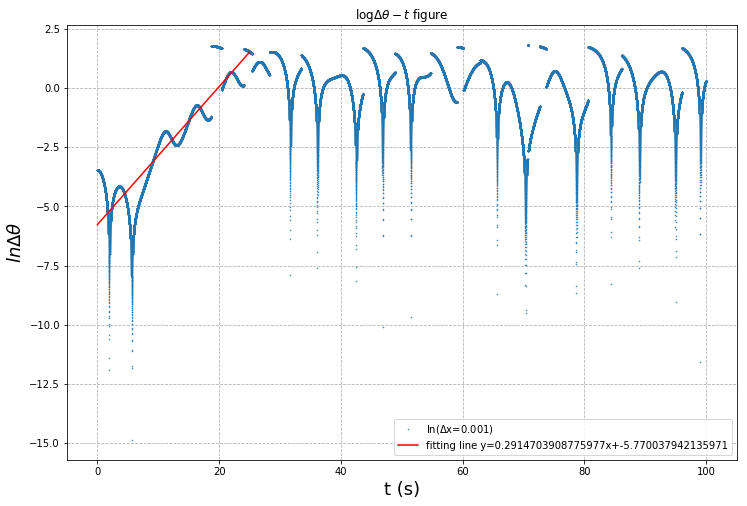

In [169]:
fig = plt.figure(figsize = [8,5])
ax1 = fig.add_subplot(111)
npoints=len(p3.xv[:,0])
trash_t=[]
trash_theta=[]
t=p1.tarray
deltatheta=np.abs(p3.xv[:,0]-p1.xv[:,0])
z=np.polyfit(t[0:25000], np.log(deltatheta)[0:25000],1)
p = np.poly1d(z)

ax1.plot(t, np.log(deltatheta), '.', markersize=1, label = "ln($\\Delta$x={})".format(x0s[1]-x0s[0]))
ax1.plot(t[0:25000],p(t[0:25000]),'r-',label='fitting line y={}x+{}'.format(z[0],z[1]))
ax1.grid(ls='--')
ax1.set_xlabel('t (s)',fontsize = 18)
ax1.set_ylabel('$ln\\Delta\\theta$', fontsize = 18)
ax1.set_title('log$\\Delta\\theta-t$ figure')
ax1.legend(loc = 4)

The line fitting shows that the slope, which is Lyapunov exponent, is about 0.2915.

**Problem 2**

<IPython.core.display.Javascript object>


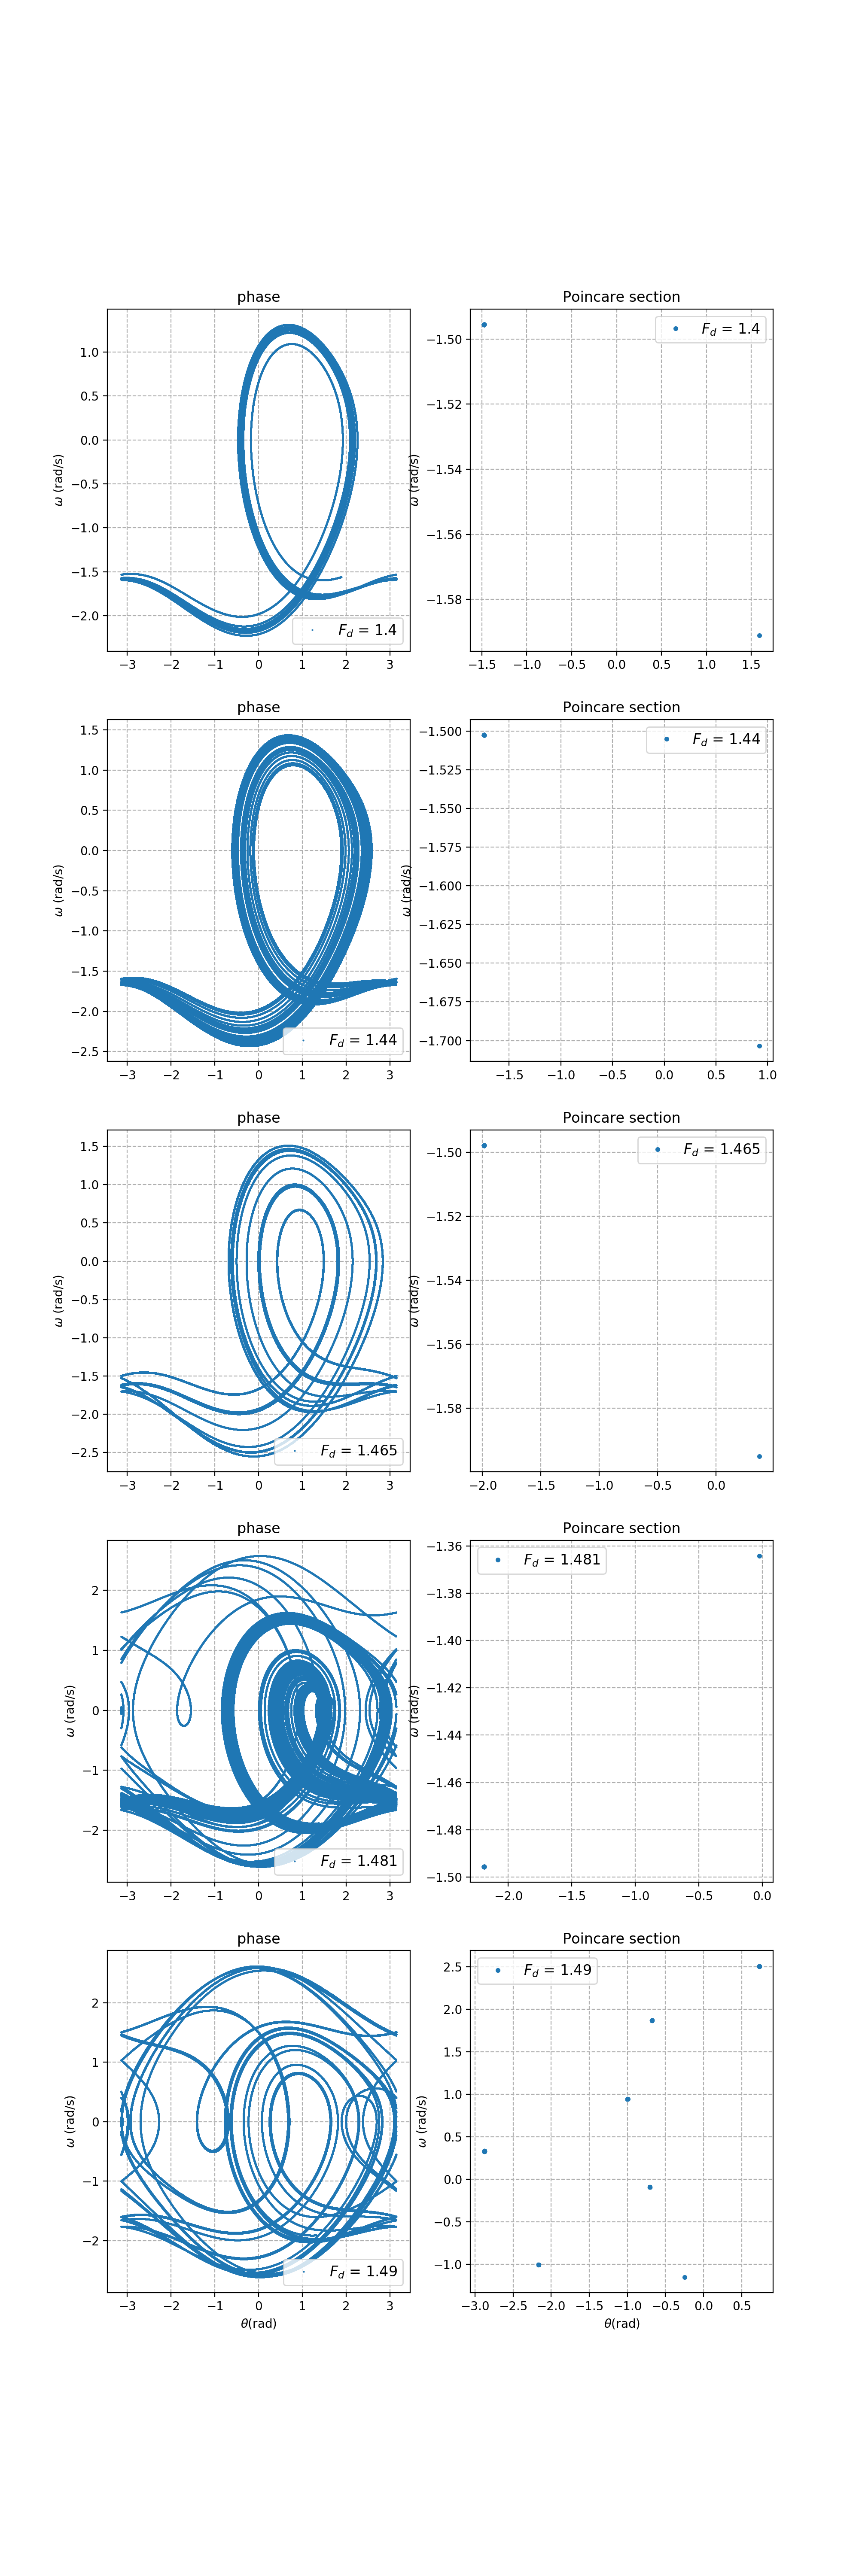

In [282]:
phi0=-1
fig = plt.figure(figsize = [10,30])
axs = fig.subplots(5,2)
FDs=[1.4, 1.44, 1.465, 1.481, 1.49]
for ii in range(5):
    p= Pendulum(nu = 0.5, Fd=FDs[ii], x0 = 0.2, omega_d = 2/3, tf= 1200, dt = 1e-3)
    p.scipy_trajectory()
    npoints1=int(np.max(np.abs(p.x_usu)/2/np.pi))
    xusual=p.x_usu[7000:-1].reshape(1192999,1)

    x_th=[]
    x_vx=[]
    for k in range(npoints1):
        d=p.x_usu[7000:-1]-(k-1)*2*np.pi-phi0; 
        [P,K]=[np.sort(abs(d)),np.argsort(abs(d))] 
        x_theta=p.xv[K[0],0];
        vx_theta=p.xv[K[0],1];
        x_th.append(x_theta)
        x_vx.append(vx_theta)

    x_th=np.array(x_th)
    x_vx=np.array(x_vx)
    axs[ii,0].plot(p.xv[7000:-1,0], p.xv[7000:-1,1],'.',markersize=1, label = "$F_d$ = {}".format(FDs[ii]))
    axs[ii,1].plot(x_th, x_vx,'.',label="$F_d$ = {}".format(FDs[ii]))
    axs[ii,1].set_ylabel('$\\omega$ (rad/s)')
    axs[ii,0].set_ylabel('$\\omega$ (rad/s)')
    axs[ii,0].set_title("phase")
    axs[ii,1].set_title("Poincare section")
    axs[ii,0].legend(loc = 4, fontsize = 12);axs[ii,1].legend(fontsize = 12)
    axs[ii,0].grid(ls='--');axs[ii,1].grid(ls='--')
axs[-1,0].set_xlabel('$\\theta$(rad)')
axs[-1,1].set_xlabel('$\\theta$(rad)')
plt.show()

The $\omega$-$\theta$ phase figure and corresponding poincare sections are shown above, where I choose to use the section $\theta=-1.0$.

**Problem 3**

In [290]:
class LogisticMap(object):

    def __init__(self, x=0.5, mu=3.2):
        self.x = x
        self.xList = [x]
        self.mu = mu
        self.muList = [mu]
            
    def map(self):        
        self.x = self.mu * self.x * (1.0 - self.x)
        self.xList.append(self.x)
        self.muList.append(self.mu)
            
    def clear(self):
        self.xList = []
        self.muList = []
        
    def iterate(self, number=1000):
        for i in range(number): self.map()
                    
    def initialize(self, transient):
        # used to remove transient
            self.iterate(transient)
            self.clear()
            
    def lyapunov(self, number = 1000, transient = 100):
        lam = 0.0
        self.initialize(transient)
        self.iterate(number)
        xList_new = np.array(self.xList)
        
        for x in xList_new:
            lam += np.log(self.mu * abs(1.0 - 2.0 * x))
        
        return lam / len(xList_new)
                        

<IPython.core.display.Javascript object>


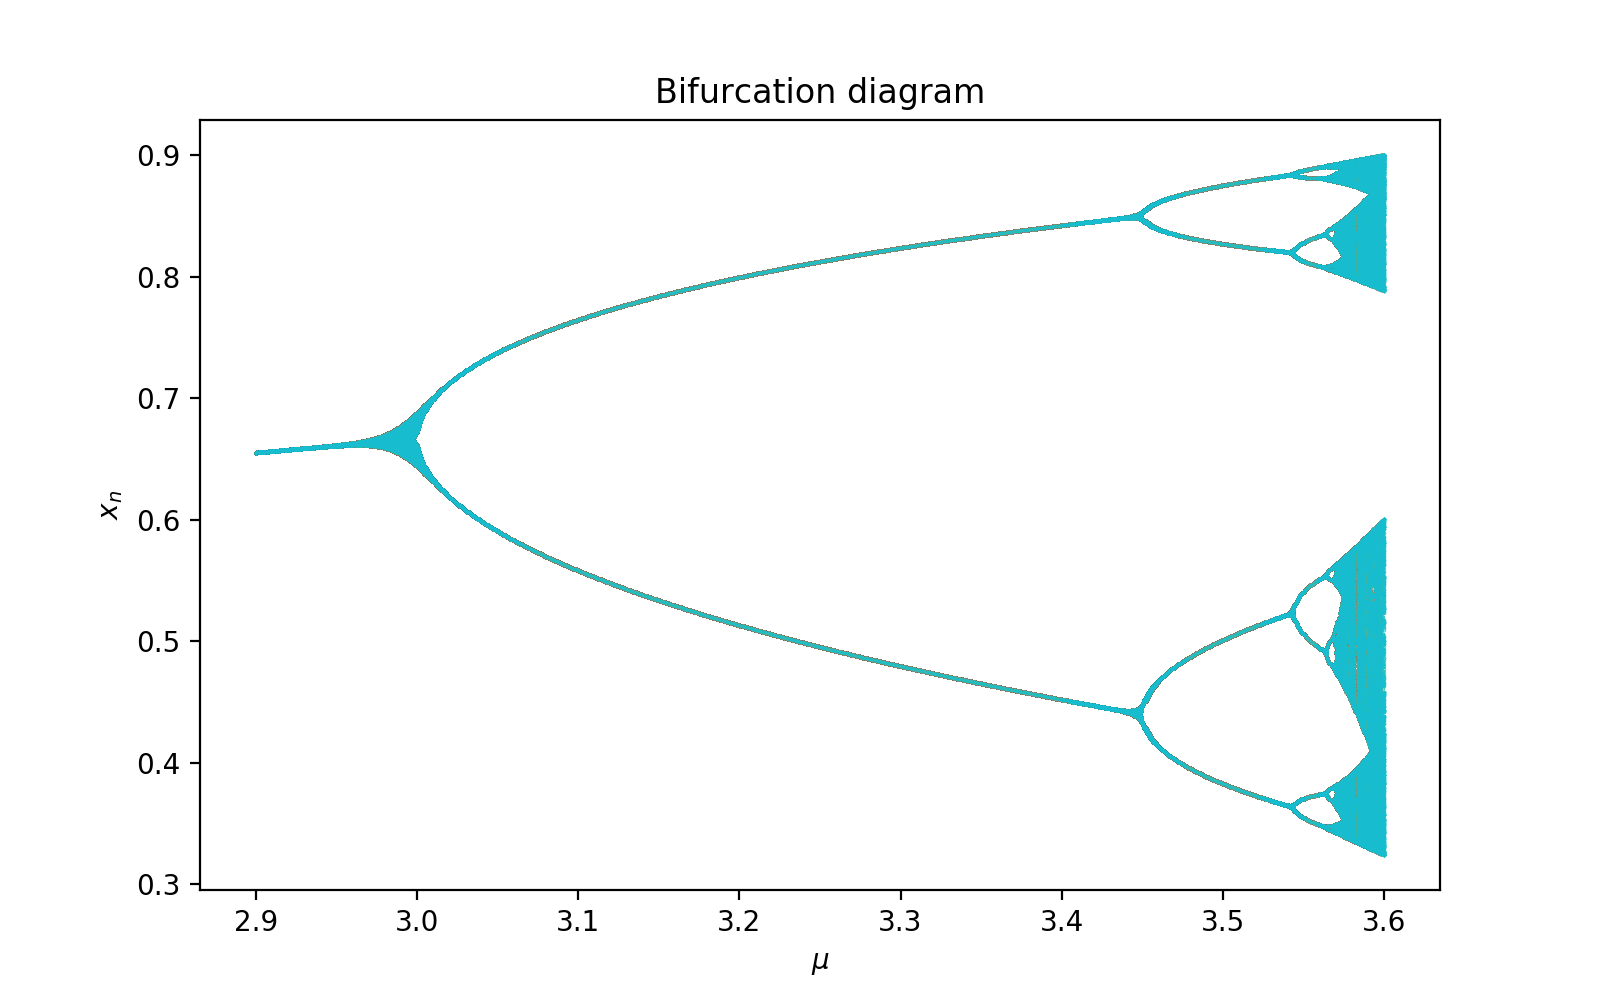

In [292]:
x0 = 0.8 

fig = plt.figure(figsize = [8,5])
axss = fig.add_subplot(111)
mu_start = 2.9
mu_stop = 3.6
mu_steps = 1000
mus = np.linspace(mu_start, mu_stop, mu_steps)   
mu_list = []
m_list = []
for mu in mus:
    m = LogisticMap(x0, mu = mu)
    m.initialize(100)      
    m.iterate(1000)
        
    m_points = np.array(m.xList)
    m_points = np.unique(np.round(m_points,8))
    
    for m in m_points:
        mu_list.append(mu)
        m_list.append(m)

    axss.plot(mu_list, m_list,'.', markersize = 0.5)      
    axss.set_xlabel('$\mu$') 
    axss.set_ylabel('$x_n$')
    axss.set_title('Bifurcation diagram')


Bifurcation diagram for logistic map with $\mu$ range from 2.9 to 3.6 is shown above. And we can calculate the Feigenbaum parameter $\delta$ by using $\delta=\frac{a_{n-1}-a_{n-2}}{a_n-a_{n-1}}$. Here we can find the following values from the figure that $a_1=3$, $a_2=3.45$, $a_3=3.5439$, $a_4=3.564$ and derive our parameter:

In [261]:
a1=3;a2=3.45;a3=3.5439;a4=3.564
delta=(a3-a2)/(a4-a3)
print('δ=',delta,'which is very close to 4.669')

δ= 4.6716417910447054 which is very close to 4.669


**Problem 4(a)**

[ 0.      0.0005  0.001  ... -0.0015 -0.001  -0.0005]


<IPython.core.display.Javascript object>


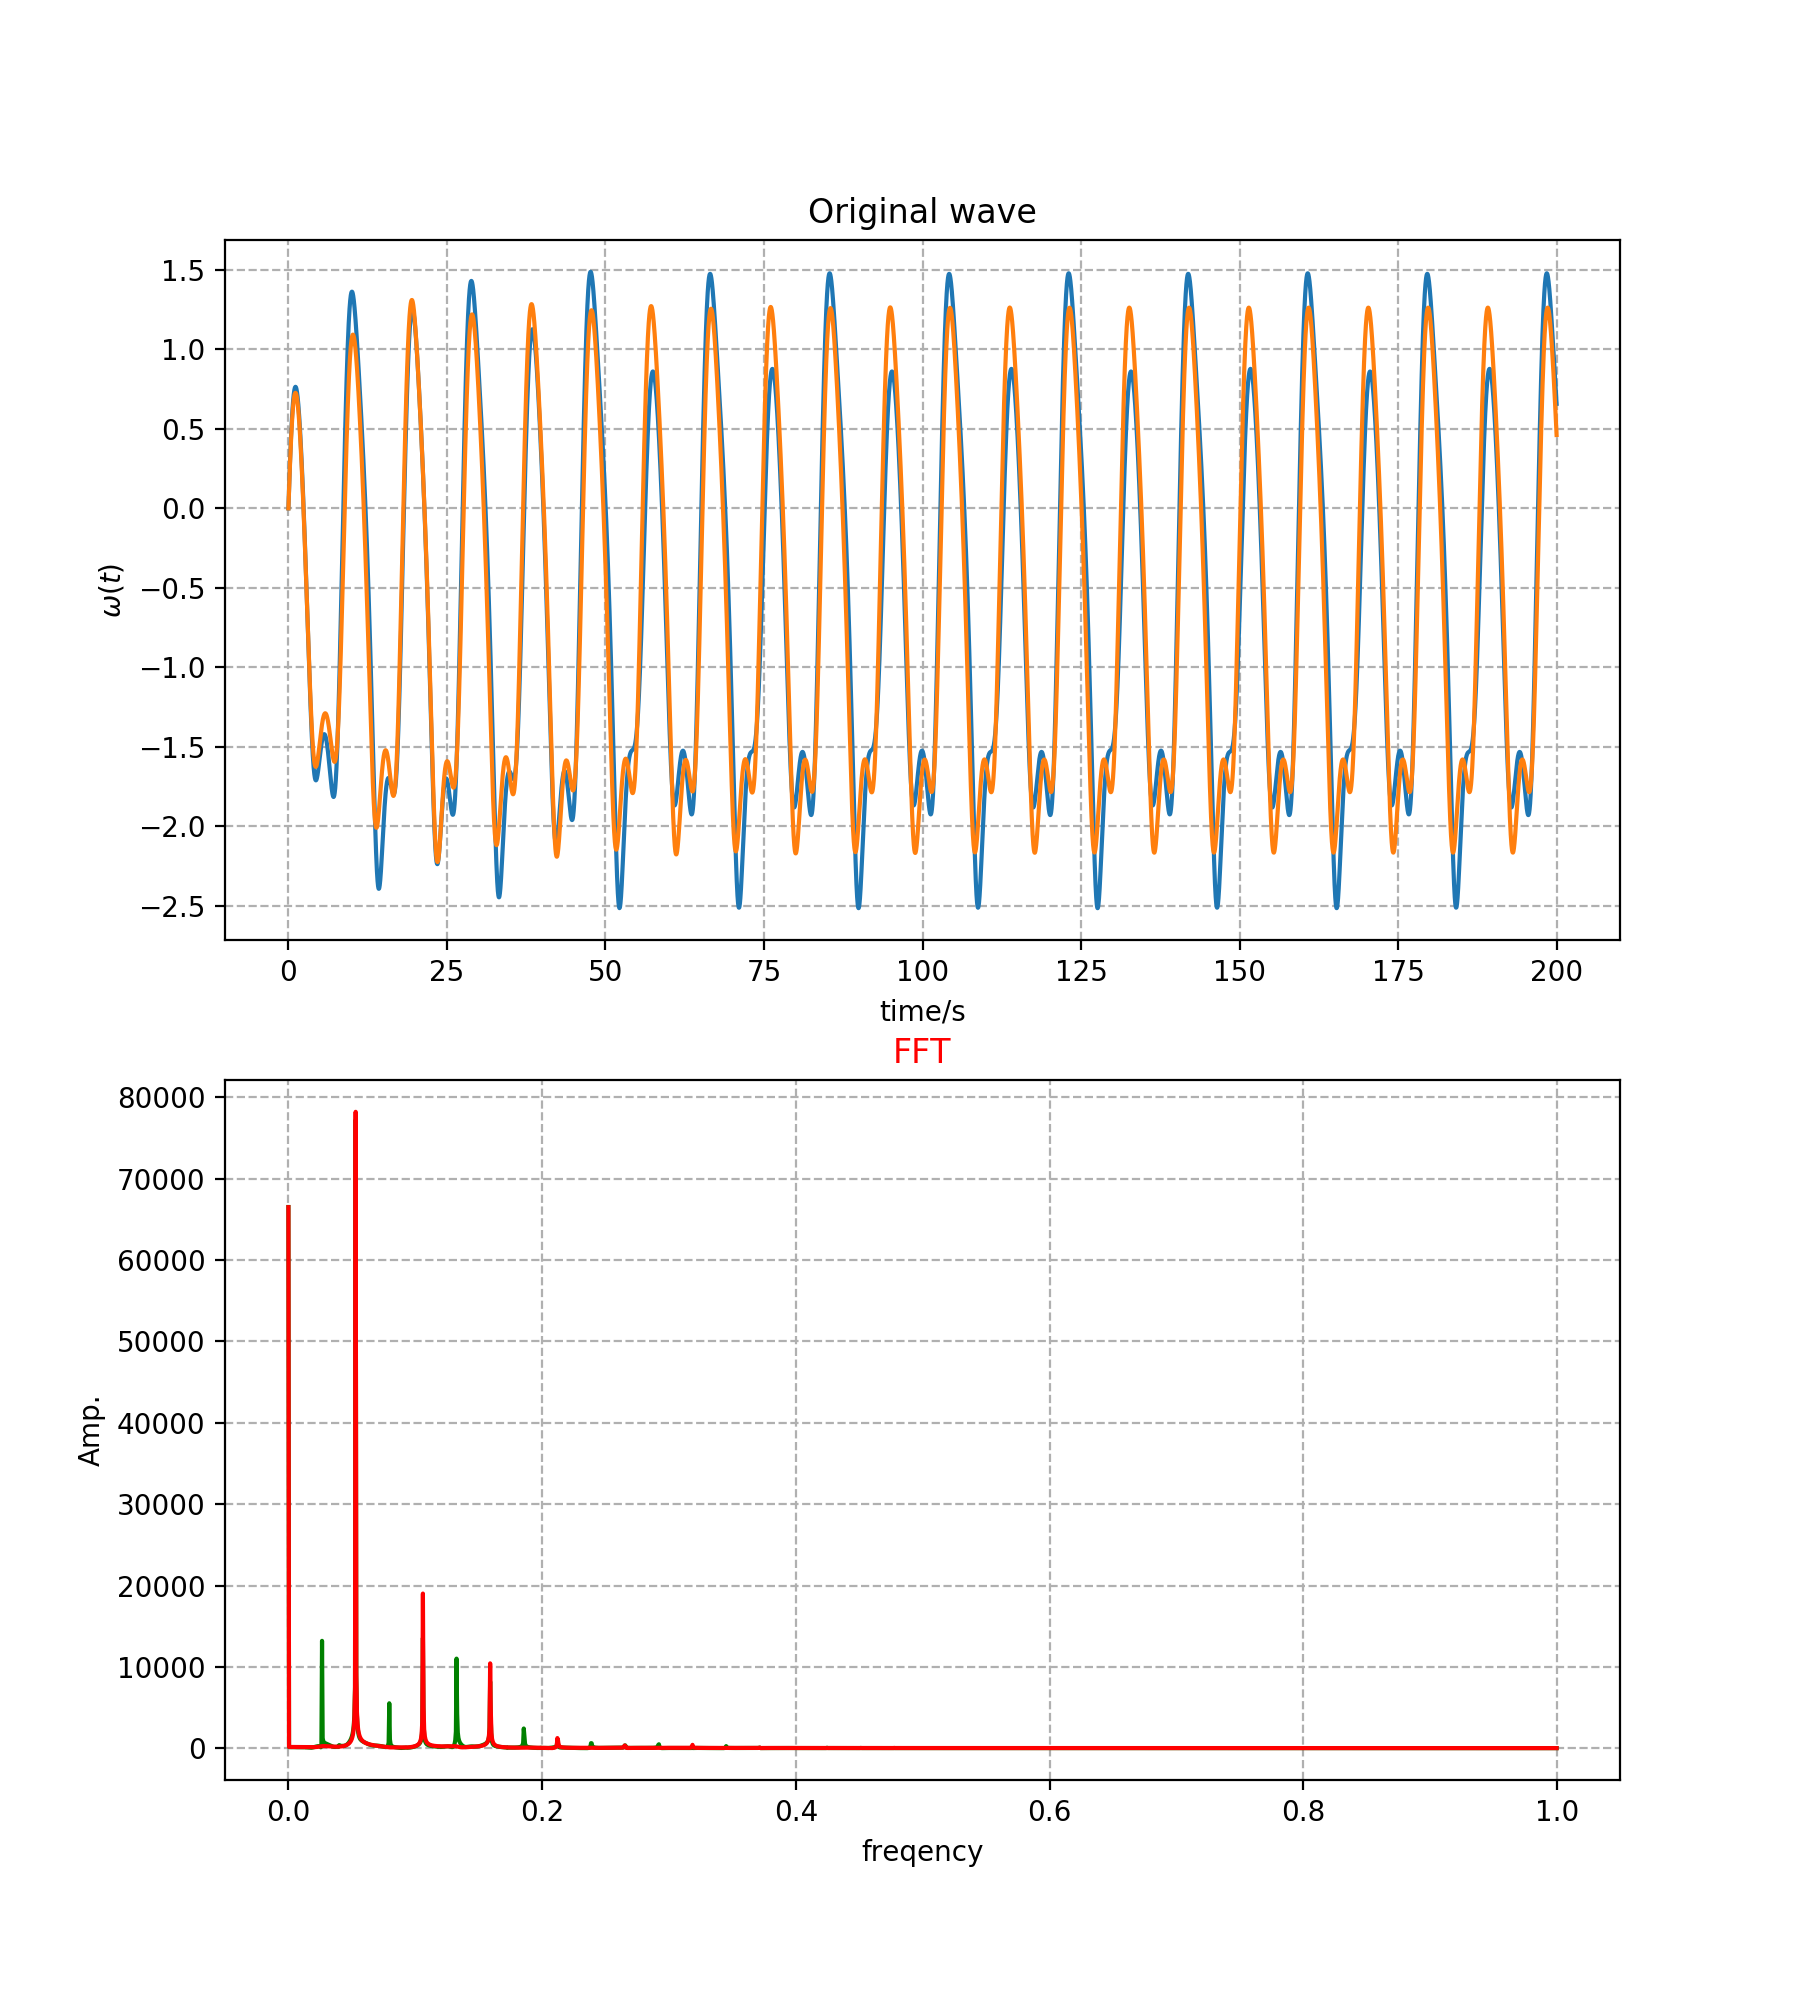

In [403]:
y=Pendulum(nu = 0.5, Fd=1.46, x0 = 0.2, omega_d = 2/3, tf= 1000, dt = 1e-2)
y.scipy_trajectory() 
yy=np.fft.fft(y.xv[:,1])                 
n_y=len(y.tarray)
yf=np.abs(yy)             
xf = np.fft.fftfreq(int(n_y/2),4e-2) 
print(xf)# freq

fig = plt.figure(figsize = [9,10])
axs11 = fig.subplots(2,1)
#Original wave
axs11[0].plot(y.tarray[0:20000],y.xv[0:20000,1])
axs11[0].set_title('Original wave')
axs11[0].set_xlabel("time/s")
axs11[0].set_ylabel("$\\omega(t)$")
axs11[0].grid(ls='--')
#FFT
axs11[1].plot(xf[0:2000],yf[0:2000],'g',markersize=2)
axs11[1].set_title('FFT',color='r')
axs11[1].set_xlabel("freqency")
axs11[1].set_ylabel("Amp.")
axs11[1].grid(ls='--')

y=Pendulum(nu = 0.5, Fd=1.4, x0 = 0.2, omega_d = 2/3, tf= 1000, dt = 1e-2)
y.scipy_trajectory() 
yy=np.fft.fft(y.xv[:,1])                 
n_y=len(y.tarray)
yf=np.abs(yy)             
xf = np.fft.fftfreq(int(n_y/2),4e-2) 

axs11[0].plot(y.tarray[0:20000],y.xv[0:20000,1])
axs11[0].set_title('Original wave')
axs11[0].set_xlabel("time/s")
axs11[0].set_ylabel("$\\omega(t)$")
axs11[0].grid(ls='--')
#FFT
axs11[1].plot(xf[0:2000],yf[0:2000],'r',markersize=2)
axs11[1].set_title('FFT',color='r')
axs11[1].set_xlabel("freqency")
axs11[1].set_ylabel("Amp.")
axs11[1].grid(ls='--')

plt.show()

One-forth of the drive frequency is included in our fast Fourier Transformation.

**Problem 4(b)**

<IPython.core.display.Javascript object>


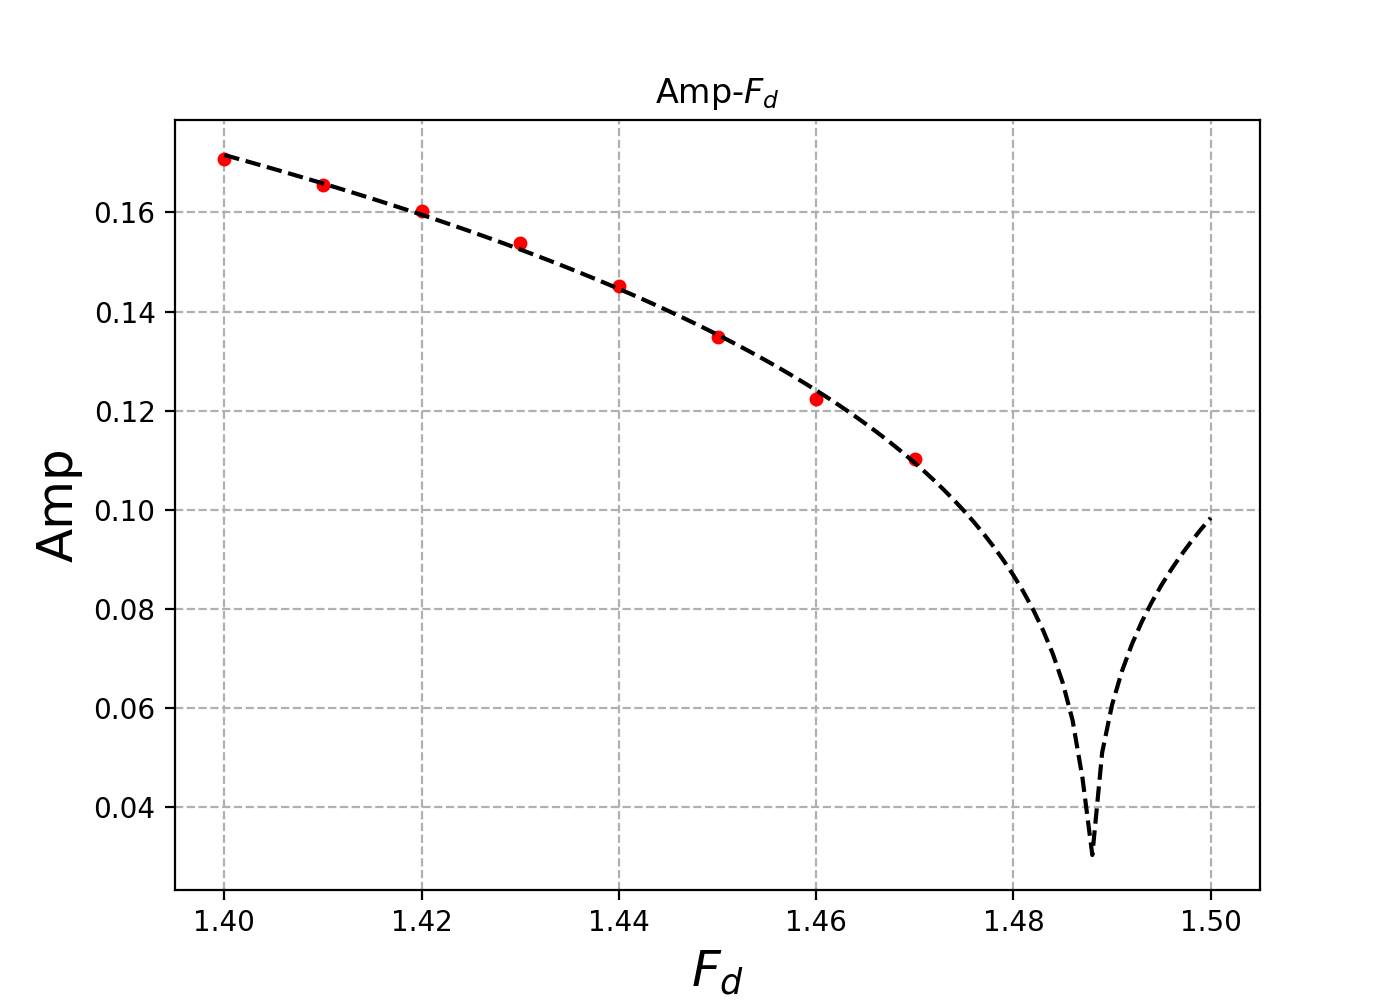

Fitting parameter: [ 0.34066121  1.48781314 -0.28188661]


In [398]:
from scipy.optimize import curve_fit
def funct(x,a,b,c):
    return a*np.abs((b-x))**(-c)

fig5 = plt.figure(figsize = [7,5])
ax5 = fig5.add_subplot(111)
x_fft =[]
freq = []
F_d=np.arange(1.4,1.47,0.01)
p_amp=[]

for x in F_d:
    p1 = Pendulum(nu = 0.5, Fd = x, omega_d = 2/3, tf= 300, dt = 1e-4) 
    p1.scipy_trajectory() 
    y = p1.xv[:,1]
    n = len(y)
    k = np.arange(n)
    T = p1.tarray[-1]
    freq = k/T
    freq = freq[range(int(n/2))]
    x_fft = np.abs(np.fft.fft(y))/n
    x_fft = x_fft[range(int(n/2))]
    fmin = np.nonzero(freq>0.2)[0]
    fmax = np.nonzero(freq<0.3)[0]
    p_amp.append(np.max(x_fft[fmin[0]:fmax[-1]]))
popt, pcov = curve_fit(funct,F_d,p_amp,p0=[0.1,1,0.1])
print('Fitting parameter:', popt)
Fd_plot = np.arange(1.4,1.5,0.001)
ax5.plot(F_d,p_amp,'r',marker='o',markersize=4,ls='')
ax5.plot(Fd_plot, funct(Fd_plot, popt[0],popt[1],popt[2]),'k',marker='',ls='--',label="curve fit")
ax5.set_ylabel('Amp',fontsize = 18)
ax5.set_xlabel('$F_d$', fontsize = 18)
ax5.set_title('Amp-$F_d$')
ax5.grid(ls='--')
plt.show()


Amplitude versus Fd figure has been plotted in Amp-Fd figure, where each transition can be easily observed.

The fitting curve can be considered as a power law behavior of phase transition. Thus, the fitting funtion of this will be:$$y=a\times|b-F_d|^{-c}$$
where a=0.34066121  b=1.48781314 c=-0.28188661, and b indicates the critical point that Amp vanishes.

**Some useful code**

In [357]:
a=np.array([0,1,2,3,2,3,21])
b=np.sort(a);c=-np.sort(-a)
print(b)
print(c)

[ 0  1  2  2  3  3 21]
[21  3  3  2  2  1  0]


In [360]:
bb=np.array([0,1,4])
cc=np.setdiff1d(a,bb)
ccc=np.setdiff1d(bb,a)
print(cc,ccc)

[ 2  3 21] [4]
